# Evaluation of mapping performance of `moscot.spatiotemporal` applied to the MOSTA dataset for Brain cells annotation

Imports mapping results after running the mapping is done search using `run_mosta_st_map_brain.py`.


In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys

In [3]:
from datetime import datetime
import numpy as np
from copy import copy
import pickle as pkl
import colorcet as cc
import glob

import scanpy as sc
import squidpy as sq
import anndata
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import warnings 
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

In [5]:
import mplscience
mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1

## Dependencies

Requires running:

1. `0_Data_preparation/ZP_2023-04-20_spatiotemporal_brain-preprocess.ipynb`: creates `mouse_embryo_all_stage_renormalized.h5ad`
2. `3_Brain_analysis/0_Brain_mapping`: creates `.pkl` files to of brain cell mappings.

Files:

1. `markers_brain.txt`: Downloaded from [MOSTA](https://db.cngb.org/stomics/mosta/download/), file [Markers_used_for_annotations_in_the_MOSTA.xlsx](https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000058/Table/Markers_used_for_annotations_in_the_MOSTA.xlsx), sheet _Markers for the E16.5 brain_


## Set parameters

In [6]:
sys.path.insert(
    0, "../../../../../"
)  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "space/spatiotemporal"
DATA_DIR = DATA_DIR / "space/spatiotemporal"


## Load processed

In [7]:
adata = sc.read(DATA_DIR / "mouse_embryo_brain_normalized.h5ad")

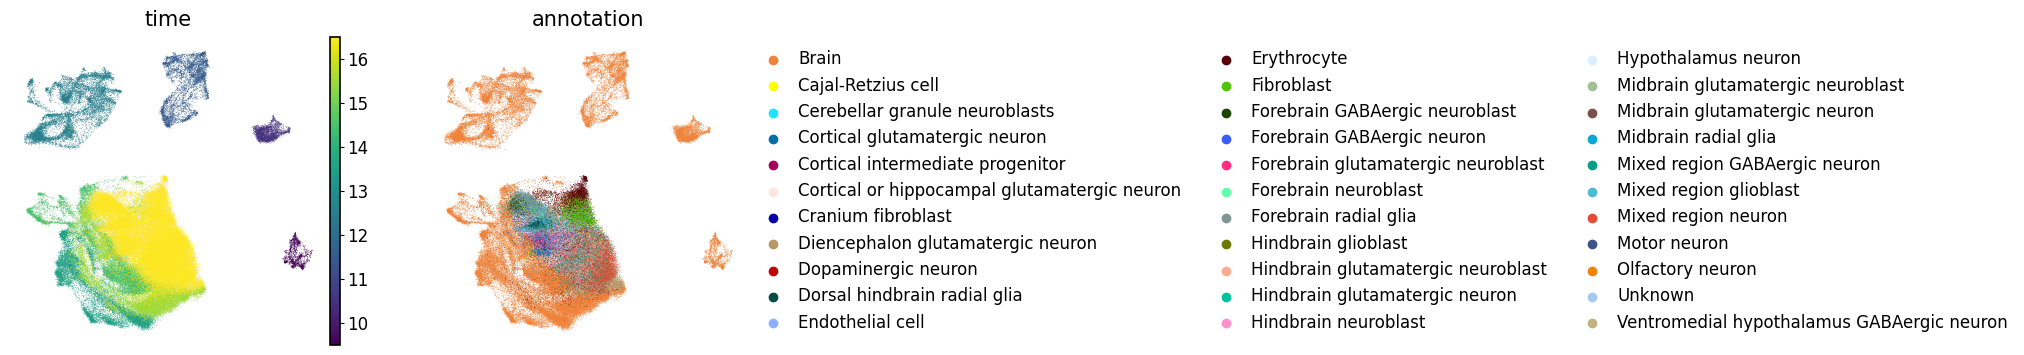

In [8]:
sc.pl.umap(adata, color=["time", "annotation"], frameon=False)

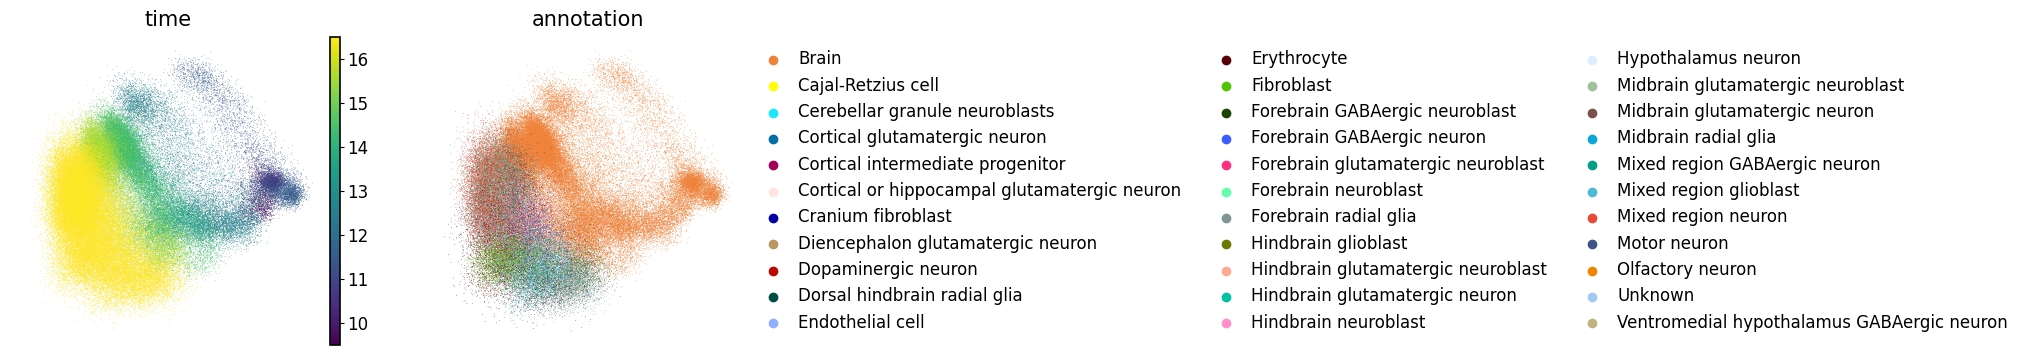

In [9]:
sc.pl.pca(adata, color=["time", "annotation"], frameon=False)

In [10]:
adata.uns["log1p"]["base"] = None

## Load mappings

In [11]:
import glob
filenames = glob.glob(str(DATA_DIR) + "/output_brain_late/*.csv")

In [12]:
res = {}
meta_data = pd.DataFrame(columns=["type", "tp","rank","gamma","epsilon","alpha"])
for file in filenames:
    split_ = file.split("/")[-1].split("_")
    epsilon = split_[-10]
    rank = split_[-8]
    gamma = split_[-6]
    alpha = split_[-4]
    tp = split_[-2]
    type_ = split_[-1].split(".")[0]
    df = pd.read_csv(file, index_col=0)
    res[f"{tp}_{type_}"] = df
    df_ = pd.DataFrame.from_dict({
            "type":[type_],
            "tp":[tp],
            "rank":[rank],
            "epsilon":[epsilon],
            "alpha":[alpha],
            "gamma":[gamma],
            })
    meta_data = pd.concat([meta_data, df_])
    

## Create `adata`

In [14]:
adatas = {}

tps_numeric = adata.obs["time"].unique()
tps_couple = [[i, i+1] for i in tps_numeric[:-1]]

In [15]:
## Map last couple
tp = 6
start, end = tps_couple[tp]

adatas[end] = adata[adata.obs["time"].isin([end])].copy()
adatas[start] = adata[adata.obs["time"].isin([start])].copy()

df_forward = res[f"{tp}_forward"]
    
adatas[start].obsm["mapping"] = df_forward.loc[adatas[start].obs_names, :]
adatas[start].obs["labels"] = adatas[start].obsm["mapping"].idxmax(axis="columns")
adatas[start].obs["labels"]  = adatas[start].obs["labels"].astype("category")

adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("Midbrain", "Mb"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("Cerebellar", "Cere"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("Hindbrain", "Hb"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("hindbrain", "Hb"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("Forebrain", "Fb"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("Cortical", "Corti"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("Hypothalamus", "hypo"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("fibroblast", "Fibro"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("glioblast", "GlioB"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("neuroblast", "NeuB"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("neuron", "Neu"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("GABAergic", "GABA"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("Cajal-Retzius cell", "CR"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("glutamatergic", "Glu"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("Erythrocyte", "Ery"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("Diencephalon", "Die"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("Endothelial cell", "Endo"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("Ventromedial hypothalamus", "VH"))
adatas[start].obs["labels"] = adatas[start].obs["labels"].cat.rename_categories(lambda x: x.replace("Dorsal", "Dors"))


adatas[end].obs["labels"] = adatas[end].obs["annotation"].copy()
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("Midbrain", "Mb"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("Cerebellar", "Cere"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("Hindbrain", "Hb"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("hindbrain", "Hb"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("Forebrain", "Fb"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("Cortical", "Corti"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("Hypothalamus", "hypo"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("fibroblast", "Fibro"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("glioblast", "GlioB"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("neuroblast", "NeuB"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("neuron", "Neu"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("GABAergic", "GABA"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("Cajal-Retzius cell", "CR"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("glutamatergic", "Glu"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("Erythrocyte", "Ery"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("Diencephalon", "Die"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("Endothelial cell", "Endo"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("Ventromedial hypothalamus", "VH"))
adatas[end].obs["labels"] = adatas[end].obs["labels"].cat.rename_categories(lambda x: x.replace("Dorsal", "Dors"))

adatas[end].uns["labels_colors"] = adatas[end].uns["annotation_colors"].copy()

sc.pp.pca(adatas[start])
sc.pp.neighbors(adatas[start])
sc.tl.umap(adatas[start])

sc.pp.pca(adatas[end])
sc.pp.neighbors(adatas[end])
sc.tl.umap(adatas[end])

adatas[start].uns["labels_colors"] = [adatas[end].uns["annotation_colors"][np.argwhere(adatas[end].obs["labels"].cat.categories == cat)[0][0]] for cat in adatas[start].obs["labels"].cat.categories]
colors_dict = {cat: adatas[end].uns["annotation_colors"][np.argwhere(adatas[end].obs["labels"].cat.categories == cat)[0][0]] for cat in adatas[end].obs["labels"].cat.categories}


In [16]:
cats = adatas[end].obs["labels"].cat.categories
group_dict = {}

for cat in cats:
    group = cat.split(" ")[0]
    if group in group_dict:
        group_dict[group].append(cat)
    else:
        group_dict[group] = [cat]
        
adatas[16.5].obs["top_labels"] = adatas[end].obs["labels"].copy().astype(str)

group_color_dict = {}
colors_dict = {}
palette = sns.color_palette(cc.glasbey, n_colors=len(group_dict))
for color_, (key_, cats_) in zip(palette, group_dict.items()):
    group_color_dict[key_] = color_
    pal = (sns.light_palette(color_, len(cats_), reverse=True).as_hex())
    colors_dict[key_] = pal
    for i, cat in enumerate(cats_):
        adatas[end].uns["labels_colors"][adatas[end].obs["labels"].cat.categories.isin([cat])] = pal[i]
        adatas[end].obs.loc[adatas[end].obs["labels"].isin([cat]) ,"top_labels"] = cats_[0]
    

adatas[end].obs["top_labels"] = adatas[end].obs["top_labels"].astype("category")     
        

In [17]:
adatas[start].uns["labels_colors"] = [adatas[end].uns["labels_colors"][np.argwhere(adatas[end].obs["labels"].cat.categories == cat)[0][0]] for cat in adatas[start].obs["labels"].cat.categories]
colors_dict = {cat: adatas[end].uns["annotation_colors"][np.argwhere(adatas[end].obs["labels"].cat.categories == cat)[0][0]] for cat in adatas[end].obs["labels"].cat.categories}


In [18]:
for tp in range(5, -1, -1):
    
    start, end = tps_couple[tp]
    adatas[start] = adata[adata.obs["time"].isin([start])].copy()
    
    df_forward = res[f"{tp}_forward"]

    df_forward = df_forward.T.loc[adatas[end].obs_names, :]
    df_forward["labels"] = adatas[end].obs["labels"]
    df_forward = df_forward.groupby("labels").sum().T
    df_forward = df_forward.loc[adatas[start].obs_names, :]
    
    
    adatas[start].obsm["mapping"] = df_forward 
    adatas[start].obs["labels"] = adatas[start].obsm["mapping"].idxmax(axis="columns")
    adatas[start].obs["labels"]  = adatas[start].obs["labels"].astype("category")    

    sc.pp.pca(adatas[start])
    sc.pp.neighbors(adatas[start])
    sc.tl.umap(adatas[start])
    
    adatas[start].uns["labels_colors"] = [adatas[end].uns["labels_colors"][np.argwhere(adatas[end].obs["labels"].cat.categories == cat)[0][0]] for cat in adatas[start].obs["labels"].cat.categories]

    

In [19]:
adata_labels = anndata.concat(adatas)

In [20]:
adata_labels.obs["labels"] = adata_labels.obs["labels"].astype("category")

In [21]:
cats = adata_labels.obs["labels"].cat.categories
group_dict = {}

adata_labels.uns["labels_colors"] = [None]*len(cats)

for cat in cats:
    group = cat.split(" ")[0]
    if group in group_dict:
        group_dict[group].append(cat)
    else:
        group_dict[group] = [cat]
        
adata_labels.obs["top_labels"] = adata_labels.obs["labels"].copy().astype(str)

group_color_dict = {}
colors_dict = {}
palette = sns.color_palette(cc.glasbey, n_colors=len(group_dict))
for color_, (key_, cats_) in zip(palette, group_dict.items()):
    group_color_dict[key_] = color_
    pal = (sns.light_palette(color_, len(cats_), reverse=True).as_hex())
    colors_dict[key_] = pal
    for i, cat in enumerate(cats_):
        idx_ = np.argwhere(adata_labels.obs["labels"].cat.categories.isin([cat]))[0][0]
        adata_labels.uns["labels_colors"][idx_] = pal[i]
        adata_labels.obs.loc[adata_labels.obs["labels"].isin([cat]) ,"top_labels"] = cats_[0]
    

adata_labels.obs["top_labels"] = adata_labels.obs["top_labels"].astype("category")     

In [22]:
min_x_155 = (adata_labels[adata_labels.obs["time"].isin([15.5])].obsm["spatial"][:, 0].min())
max_x_155 = (adata_labels[adata_labels.obs["time"].isin([15.5])].obsm["spatial"][:, 0].max())

min_y_155 = (adata_labels[adata_labels.obs["time"].isin([15.5])].obsm["spatial"][:, 1].min())
max_y_155 = (adata_labels[adata_labels.obs["time"].isin([15.5])].obsm["spatial"][:, 1].max())

diff = (min_x_155 - adata_labels[adata_labels.obs["time"].isin([14.5])].obsm["spatial"][:, 0].max())
width = (max_x_155 - min_x_155)*1.1
height = (max_y_155 - min_y_155)*0.5

min_x = (adata_labels[adata_labels.obs["time"].isin([16.5])].obsm["spatial"][:, 0].min())
min_y = (adata_labels[adata_labels.obs["time"].isin([16.5])].obsm["spatial"][:, 1].min()) + height

max_x = (adata_labels[adata_labels.obs["time"].isin([16.5])].obsm["spatial"][:, 0].max())
max_y = (adata_labels[adata_labels.obs["time"].isin([16.5])].obsm["spatial"][:, 1].max())

adata_labels.obsm["spatial_joint"] = adata_labels.obsm["spatial"].copy()
adata_labels.obsm["spatial_joint"][adata_labels.obs["time"].isin([16.5]), 0] = width*(adata_labels.obsm["spatial"][adata_labels.obs["time"].isin([16.5]), 0] - max_x) / (max_x-min_x) + (diff*5 + max_x_155)
adata_labels.obsm["spatial_joint"][adata_labels.obs["time"].isin([16.5]), 1] = height*(adata_labels.obsm["spatial"][adata_labels.obs["time"].isin([16.5]), 1] - min_y) / (min_y-max_y) + 18*max_y_155 


In [23]:
adata_labels.uns["spatial_joint"] = {"library_id": []}

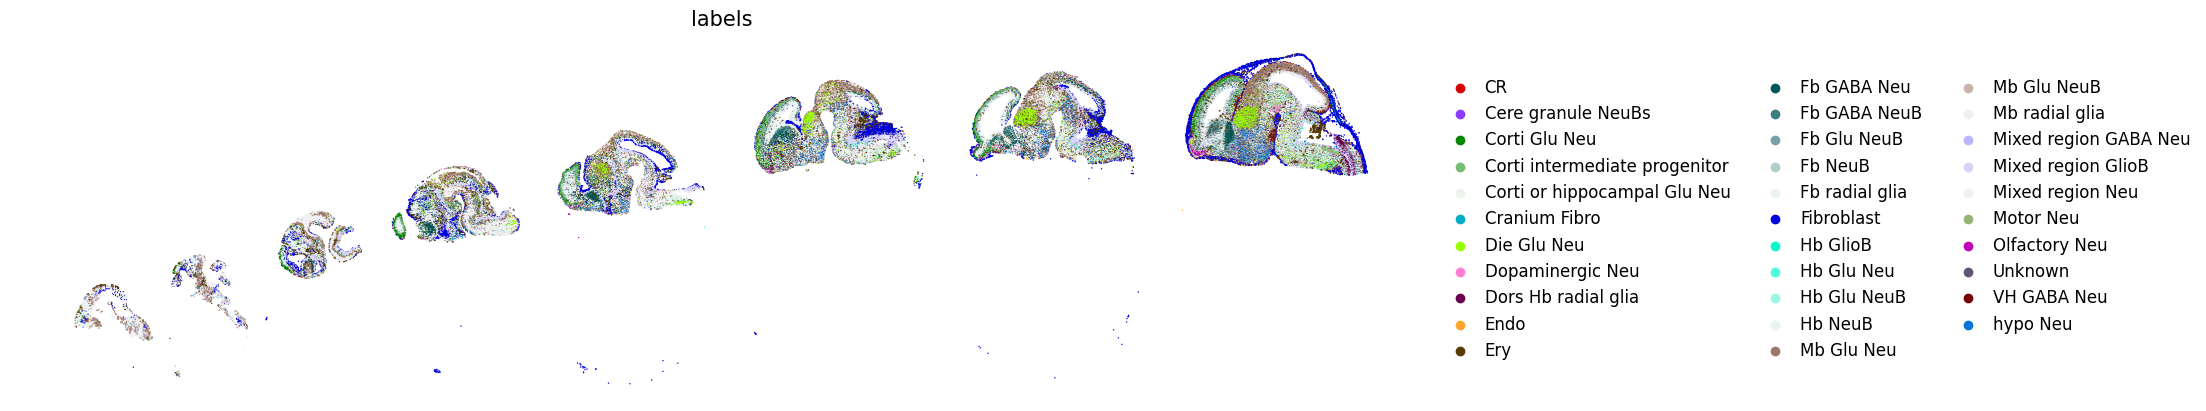

In [24]:
sq.pl.spatial_scatter(
    adata_labels,
    color=["labels"], 
    size=1.,
    spatial_key="spatial_joint",
    img=False,
    frameon=False,
    figsize=(24,4),
)
plt.show()

In [25]:
adata_labels.write(DATA_DIR / "mouse_embryo_brain_labels.h5ad")

In [26]:
with open(DATA_DIR / "colors_dict.pickle", "wb") as handle:
    pickle.dump(colors_dict, handle)

In [27]:
with open(DATA_DIR / "group_dict.pickle", "wb") as handle:
    pickle.dump(group_dict, handle)

## Asses labels - marker genes

In [28]:
adatas_hvg = {}
df_annot_genes = {}

df_ms = pd.read_csv(DATA_DIR / "markers_brain.txt", delimiter="\t", header=None, index_col=0)

In [29]:
df_ms_re_ann = df_ms.reset_index()[0].astype("category")
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("Midbrain", "Mb"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("Cerebellar", "Cere"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("Hindbrain", "Hb"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("hindbrain", "Hb"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("Forebrain", "Fb"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("Cortical", "Corti"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("Hypothalamus", "hypo"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("fibroblast", "Fibro"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("glioblast", "GlioB"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("neuroblast", "NeuB"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("neuron", "Neu"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("GABAergic", "GABA"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("Cajal-Retzius cell", "CR"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("glutamatergic", "Glu"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("Erythrocyte", "Ery"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("Diencephalon", "Die"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("Endothelial cell", "Endo"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("Ventromedial hypothalamus", "VH"))
df_ms_re_ann = df_ms_re_ann.cat.rename_categories(lambda x: x.replace("Dorsal", "Dors"))
df_ms_re_ann[:10]

0                   Fb radial glia
1                          Fb NeuB
2                      Fb Glu NeuB
3                     Fb GABA NeuB
4                      Fb GABA Neu
5                               CR
6                   Corti Glu NeuB
7     Corti or hippocampal Glu Neu
8    Corti intermediate progenitor
9                    Corti Glu Neu
Name: 0, dtype: category
Categories (36, object): ['CR', 'Cere granule NeuBs', 'Choroid plexus', 'Choroid plexus progenitor', ..., 'Mixed region Neu', 'Motor Neu', 'Olfactory Neu', 'VH GABA Neu']

In [30]:
df_ms["labels"] = df_ms_re_ann.values
df_ms = df_ms.set_index("labels")

In [31]:
for tp, adata_tp in adatas.items():
    adatas_hvg[tp] = adata_tp[:, adata_tp.var["highly_variable"]].copy()
    groups = list(adatas_hvg[tp].obs["labels"].value_counts()[adatas_hvg[tp].obs["labels"].value_counts() > 100].index)
    print(f"{tp}: {len(groups)}")
    sc.tl.rank_genes_groups(adatas_hvg[tp], groupby="labels", groups=groups)
    cols_ = sc.get.rank_genes_groups_df(adatas_hvg[tp], group=None)
    df_annot_genes[tp] = pd.DataFrame(columns=cols_.columns)
    
    for gr in groups:
        if gr == "Unknown":
            continue
        df_genes_gr = sc.get.rank_genes_groups_df(adatas_hvg[tp], group=gr)
        tmp = df_genes_gr[df_genes_gr["names"].isin(df_ms.loc[gr, :].values)].copy()
        tmp["group"] = gr
        tmp["index"] = tmp.index
        df_annot_genes[tp] = pd.concat((df_annot_genes[tp], tmp), ignore_index=True)
        
        

16.5: 32


/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: Perform

15.5: 20
14.5: 20
13.5: 15
12.5: 15
11.5: 9
10.5: 6
9.5: 4


We can look at the distribution of the index of the cell-type marker genes (2 per cell type) in the `rank_genes_groups` per cell-type

In [32]:
X = 50
topX = {}
topX_single = {}
for tp, df_annot_genes_ in df_annot_genes.items(): 
    topX[tp] = (df_annot_genes_["index"] < X).values.sum() / df_annot_genes_.shape[0]

In [33]:
topX_df = pd.DataFrame(topX, index=[f"Top{X}"]).T.reset_index()
topX_df = topX_df[topX_df["index"] < 16.5]
topX_df["timepoint"] = [f"E{tp}" for tp in topX_df["index"]]

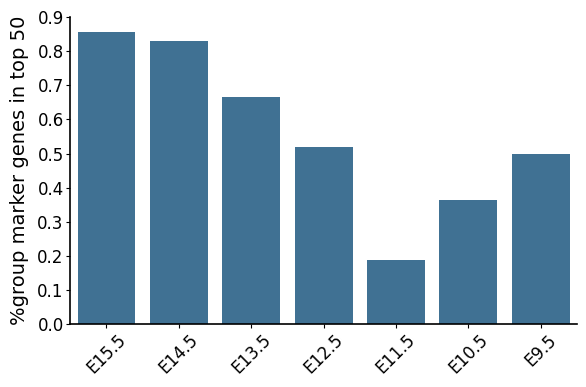

In [34]:
rows, cols = 1, 1
size = 4
fig, axs = plt.subplots(rows, cols, figsize=(cols*(2+size), size*rows))

sns.barplot(
    data=topX_df,
    x="timepoint",
    y=f"Top{X}",
    color="#3274A1"
)

plt.xlabel("")
plt.ylabel(f"%group marker genes in top {X}")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(FIG_DIR / "brain_top50.png", bbox_inches="tight", transparent=True, dpi=300)
plt.show()

In [35]:
cell_types = [
    "Fb Glu NeuB",
    "Die Glu Neu",
]

Fb Glu NeuB


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


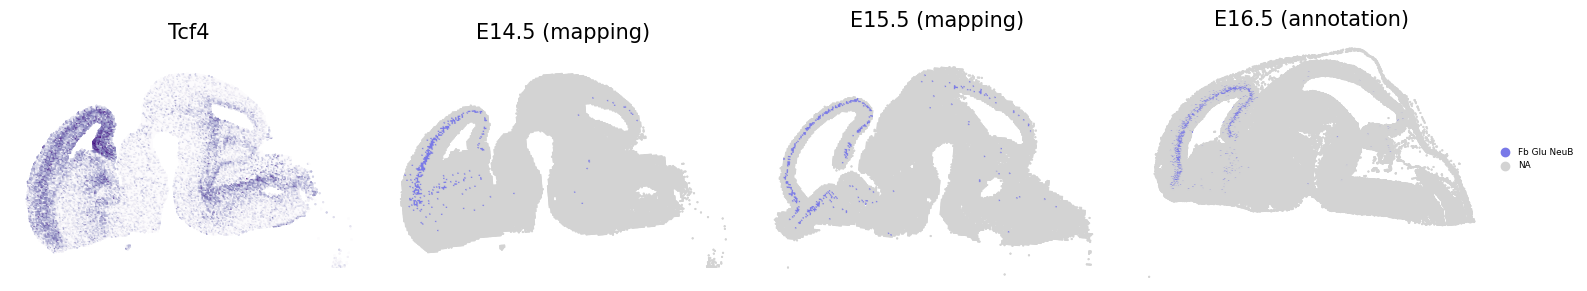

Die Glu Neu


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


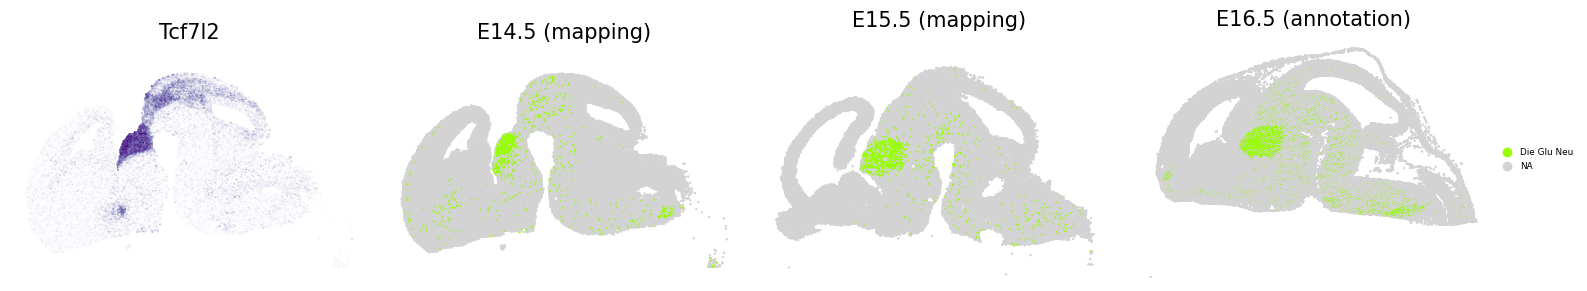

In [36]:
for i, gr in enumerate(cell_types):
    print(gr)
    n_annot = 4
    rows, cols = 1, n_annot
    size = 4
    fig, axs = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    
    adatas_hvg[15.5].obs[gr] = np.nan
    adatas_hvg[15.5].obs.loc[adatas_hvg[15.5].obs["labels"].isin([gr]), gr] = gr
    adatas_hvg[15.5].uns[f"{gr}_colors"] = [adatas_hvg[15.5].uns["labels_colors"][adatas_hvg[15.5].obs["labels"].cat.categories.isin([gr])][0]]
    
    
    adatas_hvg[16.5].obs[gr] = np.nan
    adatas_hvg[16.5].obs.loc[adatas_hvg[16.5].obs["labels"].isin([gr]), gr] = gr
    adatas_hvg[16.5].uns[f"{gr}_colors"] = [adatas_hvg[16.5].uns["labels_colors"][adatas_hvg[16.5].obs["labels"].cat.categories.isin([gr])][0]]
    
    
    adatas_hvg[14.5].obs[gr] = np.nan
    adatas_hvg[14.5].obs.loc[adatas_hvg[14.5].obs["labels"].isin([gr]), gr] = gr
    adatas_hvg[14.5].uns[f"{gr}_colors"] = [adatas_hvg[14.5].uns["labels_colors"][adatas_hvg[14.5].obs["labels"].cat.categories.isin([gr])][0]]
    
    
    sq.pl.spatial_scatter(
        adatas_hvg[16.5],
        spatial_key="spatial",
        color=gr,
        shape=None,
        na_color="lightgrey",
        size=1,
        frameon=False,
        figsize=(10, 10),
        title=f"E16.5 (annotation)",
        legend_fontsize="xx-small",
        ax=axs[3],
    )
        
    sq.pl.spatial_scatter(
        adatas_hvg[15.5],
        spatial_key="spatial",
        color=gr,
        shape=None,
        na_color="lightgrey",
        size=1,
        frameon=False,
        figsize=(10, 10),
        title=f"E15.5 (mapping)",
        legend_fontsize="xx-small",
        ax=axs[2],
    )
    
    sq.pl.spatial_scatter(
        adatas_hvg[14.5],
        spatial_key="spatial",
        color=gr,
        shape=None,
        na_color="lightgrey",
        size=1,
        frameon=False,
        figsize=(10, 10),
        title=f"E14.5 (mapping)",
        legend_fontsize="xx-small",
        ax=axs[1],
    )
    
    if df_ms.loc[gr, :].values[0] in adatas_hvg[14.5].var_names:
        sq.pl.spatial_scatter(
            adatas_hvg[14.5],
            spatial_key="spatial",
            color=df_ms.loc[gr, :].values[0],
            shape=None,
            size=1,
            frameon=False,
            figsize=(10, 10),
            title=df_ms.loc[gr, :].values[0],
            legend_fontsize="xx-small",
            cmap="Purples",
            colorbar=False,
            ax=axs[0],
        )
    
    axs[0].legend().remove()
    axs[1].legend().remove()
    axs[2].legend().remove()
    

    axs[3].set_ylim([-11200, -600])
    axs[0].set_ylim(-300)
    axs[1].set_ylim(-300)
    axs[2].set_ylim(-300)
    
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"brain_ct_{gr}.png", bbox_inches="tight", transparent=True, dpi=300)
    plt.show()